<a href="https://colab.research.google.com/github/hyunsoo41/DeepLearning/blob/main/practice05_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Settings

1) Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

2) Hyperparameter

In [2]:
batch_size = 16
learning_rate = 0.0001
epoch = 20

n_node = 1024
dropratio = 0.5

imgsize = 256

# 2. Data Loader

트레이닝 데이터

In [3]:
img_dir = "food/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(imgsize*2),
            transforms.RandomCrop(imgsize),
            transforms.RandomHorizontalFlip(),
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, num_workers=2)

68


고정된 데이터셋

In [4]:
# Dev data
img_dir = "food/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
           #transforms.Scale(256),
           #transforms.RandomSizedCrop(224),
    
           transforms.CenterCrop(size=imgsize),
           transforms.Resize(imgsize),
           transforms.ToTensor()
           ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                           shuffle=False, num_workers=2)

# Test data
img_dir = "food/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
           #transforms.Scale(256),
           #transforms.RandomSizedCrop(224),
    
           transforms.CenterCrop(size=imgsize),
           transforms.Resize(imgsize),
           transforms.ToTensor()
           ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                           shuffle=False, num_workers=2)

nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
      %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

#for img, labels in train_batch:
#    for j in range(len(imgs)):
#        img = transforms.ToPILImage()(imgs[j])
#        plt.title("label: %d" %labels[j])
#        plt.imshow(img)
#        plt.show()

# of classes: 3
['applepie', 'pizza', 'salad']
{'applepie': 0, 'pizza': 1, 'salad': 2}
68
Training: 68, Dev: 30, Test: 59


In [5]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['applepie', 'pizza', 'salad']
['applepie', 'pizza', 'salad']
['applepie', 'pizza', 'salad']


# 3. Model

1)Pretrained VGG Module

In [6]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

#cnt = 0
#for i in model.children():
#    print("yhk[%d]" %cnt),
#    print(i)
#    cnt = cnt+1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [7]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


2) Customized Fully Model

In [8]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, nclass),
        )
        
        # weight initialization
        for m in self.layer1.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        # print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

3) Model in GPU

In [9]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [10]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# 5. Train

In [12]:
import utils

total_time = 0
disp_step = 10

to_train = True
if(to_train == False):
    netname = 'food_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, deb: %.2f, test: %.2f"
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = 'food_vgg19'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0 - train_corr)
    y_dev_err.append(100.0 - dev_corr)
    y_test_err.append(100.0 - test_corr)
    
#    # 학습을 재시작한다면
#    netname 'media_pre_vgg19.pkl'
#    model = torch.load(netname)
#    # 파라미터 학습 여부 결정
#    for params in model.layer0.parameters():
#        params.required_grad = False
#    for params in model.layer1.parameters():
#        params.required_grad = True
#    for i in range(34, epoch):

    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i == epoch-1):
            torch.save(model, netname + '_%d.pkl' %i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            model.eval()
            
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                  %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 38.24, deb: 30.00, test: 38.98
0..

[0/20] loss: 0.751, 
Correct of train: 55.88, dev: 50.00, test: 61.02, 
time: 2.02 sec..
Total time: 2.02 sec
1..
Total time: 4.03 sec
2..
Total time: 6.06 sec
3..
Total time: 8.23 sec
4..
Total time: 10.09 sec
5..
Total time: 12.10 sec
6..
Total time: 13.98 sec
7..
Total time: 16.16 sec
8..
Total time: 18.09 sec
9..
Total time: 20.26 sec
10..

[10/20] loss: 1.036, 
Correct of train: 91.18, dev: 83.33, test: 89.83, 
time: 22.18 sec..
Total time: 22.18 sec
11..
Total time: 24.11 sec
12..
Total time: 26.02 sec
13..
Total time: 28.00 sec
14..
Total time: 29.91 sec
15..
Total time: 31.85 sec
16..
Total time: 33.84 sec
17..
Total time: 35.94 sec
18..
Total time: 37.84 sec
19..

[19/20] loss: 0.341, 
Correct of train: 91.18, dev: 83.33, test: 88.14, 
time: 39.80 sec..
Total time: 39.80 sec


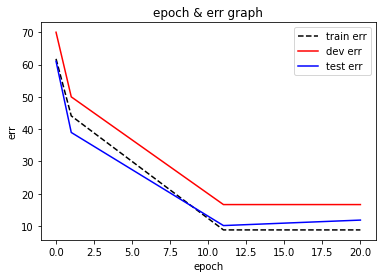

In [13]:
# epoch_err curve
if(to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc='upper right')
    plt.show()

# 6. Evaluation for dev & test data

Normalized confusion matrix


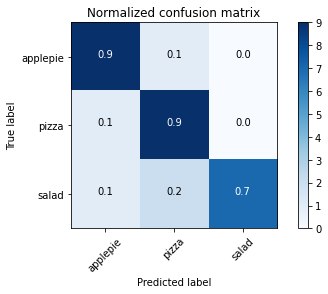

Confusion matrix, without normalization


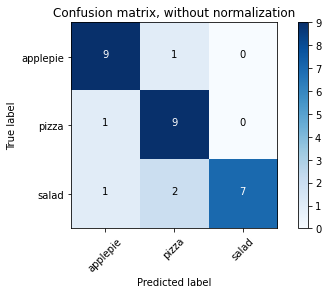

	 acc  |	 pre  |	 rec  |	 f1
 applepie: 0.90 |	 0.82 |	 0.90 |	 0.86
 pizza: 0.83 |	 0.75 |	 0.90 |	 0.82
 salad: 0.90 |	 1.00 |	 0.70 |	 0.82
*accuracy: 0.88, precision: 0.86, recall: 0.83, *f1 score: 0.83
[AP]
applepie: 0.97
pizza: 0.89
salad: 0.96

[mAP] 0.939
[miAP] 0.933


(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2,
        2, 2, 2, 0, 1, 2, 2, 2]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2]),
 array([0.97477537, 0.56577861, 0.64668351, 0.79080069, 0.92667264,
        0.88789761, 0.84979963, 0.86889195, 0.83306783, 0.96734107,
        0.93560255, 0.43262175, 0.55820447, 0.59311461, 0.95328617,
        0.99273372, 0.96578479, 0.92505753, 0.95250392, 0.66435134,
        0.88162333, 0.81853914, 0.99375272, 0.84249496, 0.99419415,
        0.36807257, 0.83045846, 0.74174672, 0.82483649, 0.91927379]))

In [14]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


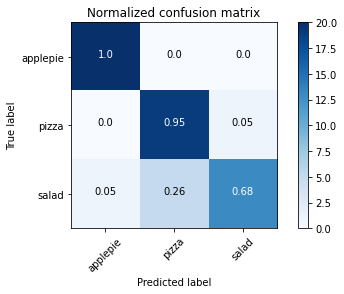

Confusion matrix, without normalization


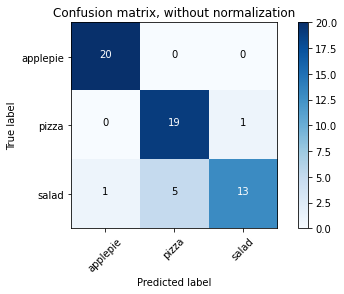

	 acc  |	 pre  |	 rec  |	 f1
 applepie: 0.98 |	 0.95 |	 1.00 |	 0.98
 pizza: 0.88 |	 0.79 |	 0.95 |	 0.86
 salad: 0.88 |	 0.93 |	 0.68 |	 0.79
*accuracy: 0.92, precision: 0.89, recall: 0.88, *f1 score: 0.88
[AP]
applepie: 1.00
pizza: 0.95
salad: 0.92

[mAP] 0.956
[miAP] 0.955


In [15]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: applepie
 True predicted images/total applepie category: 9 / 10
Predicted probability:
[0.9747754  0.0113622  0.01386243]


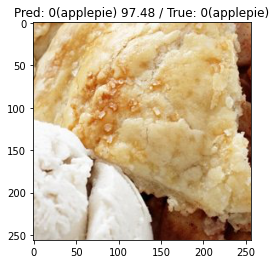

Predicted probability:
[0.6466835  0.33771226 0.01560422]


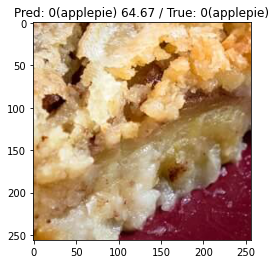

 False predicted images/total applepie category: 1 / 10
Predicted probability:
[0.34291556 0.5657786  0.09130582]


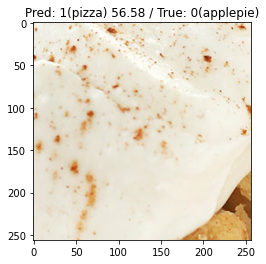

Category: pizza
 True predicted images/total pizza category: 9 / 10
Predicted probability:
[0.0301937  0.93560255 0.03420373]


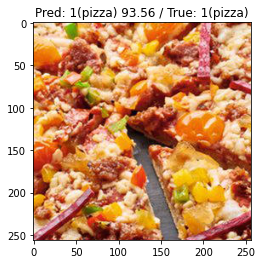

Predicted probability:
[0.36995587 0.43262175 0.1974224 ]


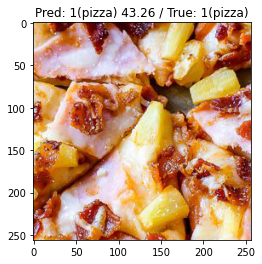

 False predicted images/total pizza category: 1 / 10
Predicted probability:
[0.66435134 0.27228424 0.06336442]


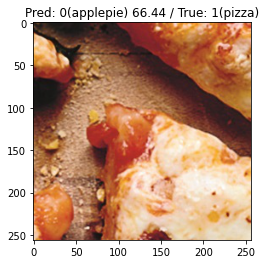

Category: salad
 True predicted images/total salad category: 7 / 10
Predicted probability:
[0.12165079 0.05981005 0.81853914]


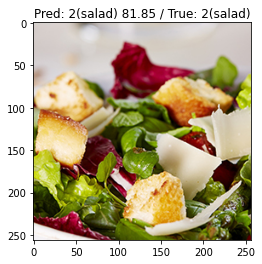

Predicted probability:
[0.00257964 0.00366764 0.9937527 ]


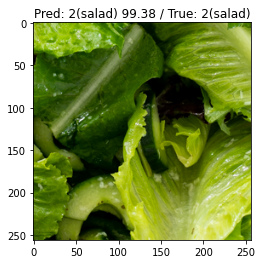

 False predicted images/total salad category: 3 / 10
Predicted probability:
[0.02480136 0.8816233  0.09357531]


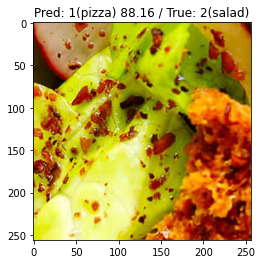

Predicted probability:
[0.36807257 0.34847802 0.28344938]


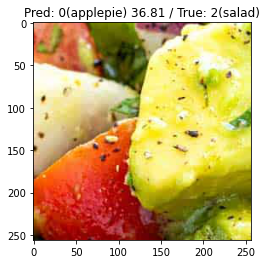

In [16]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)